In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.model_selection import cross_validate
import shap

Feature Name Dictionary: https://github.com/transplantation/unos-ht/blob/master/data/Interpretation_type.csv

Example Research: https://rstudio-pubs-static.s3.amazonaws.com/450330_2d750c82d01e4ecdb63acac851f3695e.html

In [2]:
# Function to calculate the core metrics and print table with values
def metrics(y_test, y_pred):
    from sklearn import metrics
    import plotly.graph_objects as go

    # Calculate each metric using the sklearn library
    # Pass in the model's predictions, the correct values, and the decimal places to round to
    accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
    precision = round(metrics.precision_score(y_test, y_pred),3)
    recall = round(metrics.recall_score(y_test, y_pred),3)
    specificity = round(metrics.recall_score(y_test, y_pred, pos_label=0),3)
    f1_score = round(metrics.f1_score(y_test, y_pred),3)
    auc_roc = round(metrics.roc_auc_score(y_test, y_pred),3)

    metric_vals = ['Accuracy','Precision','Recall','Specificity','F1 Score','AUC ROC']
    scores = [accuracy, precision, recall, specificity, f1_score, auc_roc]

    # Create the table
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Metric', 'Score'],
                    line_color='darkslategray',
                    fill_color='lightskyblue',
                    align='left'),
        cells=dict(values=[metric_vals, # 1st column
                        scores], # 2nd column
                line_color='darkslategray',
                fill_color='lightcyan',
                align='left'))
    ])

    # Specify figure dimenstions and show the table
    fig.update_layout(width=350, height=350)
    fig.show()

In [3]:
# Pie chart for classification of successful transplants
def transplants_pie_chart(status, correct, incorrect):
    labels_surv = ['Correctly Classified','Incorrectly Classified']
    sizes_surv = [correct,incorrect]

    colors = ['#3262AC','#70B7EF']

    fig1, ax1 = plt.subplots()
    patches, texts, autotexts = ax1.pie(sizes_surv, colors = colors, labels=labels_surv, autopct='%1.1f%%', startangle=45)
    for text in texts:
        text.set_color('black')
        text.set_fontsize(20)
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(20)
        
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  

    # Conditionally assign the pie chart's title
    if status == 'success':
        title = 'Classification Rates for Successful Heart Transplants'
    elif status == 'failed':
        title = 'Classification Rates for Failed Heart Transplants'

    # Set the title and show the pie chart
    plt.suptitle(title, fontsize = 24)
    plt.show()

In [4]:
# Import the dataset

cleanedDataset365 = pd.read_csv("cleanedDataset365.csv", low_memory=False)

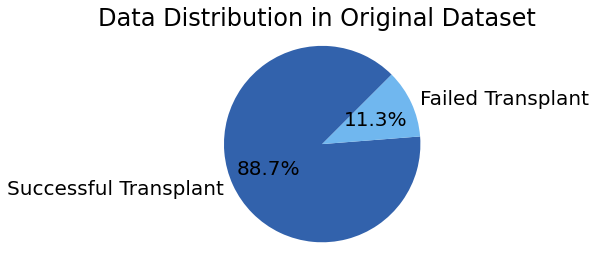

In [5]:
# Pie chart for total data distribution in the original dataset

data_labels = ['Successful Transplant','Failed Transplant']
data_sizes = [cleanedDataset365['365DaySurvival'].value_counts()[True],cleanedDataset365['365DaySurvival'].value_counts()[False]]

colors = ['#3262AC','#70B7EF']

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(data_sizes, colors = colors, labels=data_labels, autopct='%1.1f%%', startangle=45)
for text in texts:
    text.set_color('black')
    text.set_fontsize(20)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(20)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.suptitle('Data Distribution in Original Dataset', fontsize = 24)
plt.show()

In [6]:
physician_specified_columns = ['365DaySurvival','GENDER',
'LV_EJECT',
'NUM_PREV_TX',
'DAYSWAIT_CHRON',
'ABOMAT',
'TX_YEAR',
'mcs',
'PHMratio',
'vol_quartile',
'TBILI',
'PROTEIN_URINE',
'AGE']

In [7]:
# Feature engineering to convert physician-specified features to types for the model
cleanedDataset365['GENDER'] = cleanedDataset365['GENDER'].map({'M':0, 'F':1})
cleanedDataset365['ABOMAT'] = cleanedDataset365['ABOMAT'].map({'ABO incompatible':0, 'ABO compatible':1, 'ABO identical':2})
cleanedDataset365['PROTEIN_URINE'] = cleanedDataset365['PROTEIN_URINE'].astype(bool)

In [8]:
# Create dataframe based on the features physicians called out as important (except mcs)
df_1 = cleanedDataset365.filter(['365DaySurvival','GENDER','LV_EJECT',
                                 'NUM_PREV_TX','DAYSWAIT_CHRON','ABOMAT',
                                 'TX_YEAR','PHMratio','vol_quartile','TBILI',
                                 'PROTEIN_URINE','AGE'], axis=1)

Model 1: XGBoost classifier algorithm with physician-specified features

0.9218006729318946


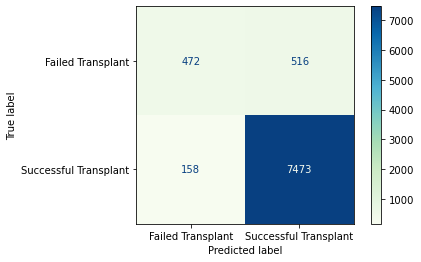

In [9]:
# Model from physician-supplied features (except mcs)

X = df_1.drop(['365DaySurvival'], axis = 1)
y = df_1['365DaySurvival']

model = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

metrics(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Failed Transplant','Successful Transplant'], cmap = 'GnBu')
plt.show()

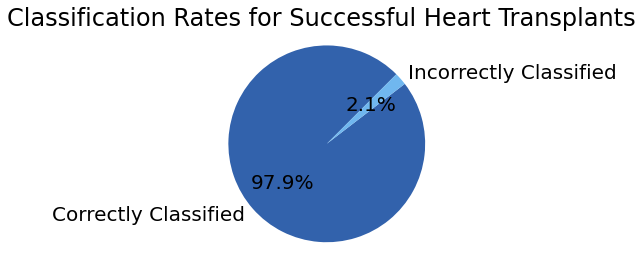

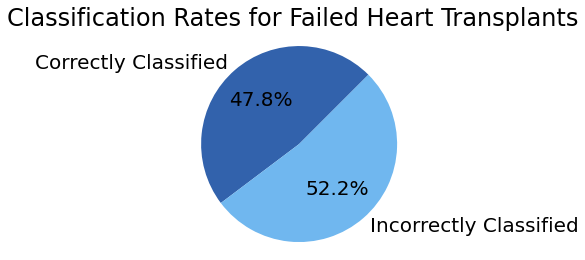

In [10]:
# Pie chart for classification of successful and failed transplants

transplants_pie_chart('success',7473,158)
transplants_pie_chart('failed',472,516)

Model 2: XGBoost classifier algorithm with all integer, bool, and float features

In [11]:
# Create a new dataset that removes all other data types for the model
filtered_df = cleanedDataset365.select_dtypes(include=['int64','float64','bool'])

# Remove the index column
filtered_df = filtered_df.drop(['Unnamed: 0'], axis=1)

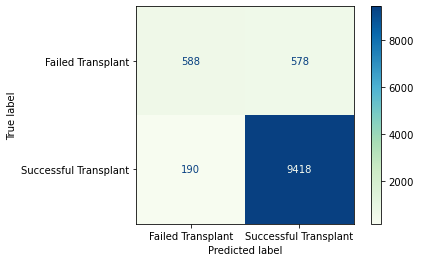

In [12]:
# Model from all non-object-type features after feature engineering

X = filtered_df.drop(['365DaySurvival'], axis = 1)
y = filtered_df['365DaySurvival']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create, fit, and implement the model
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create the confusion matrix to visualize results
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Failed Transplant','Successful Transplant'], cmap = 'GnBu')
plt.show()

In [13]:
metrics(y_test, y_pred)

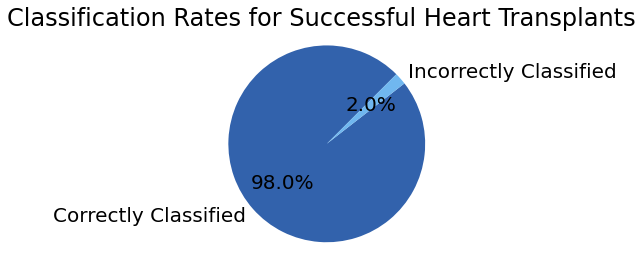

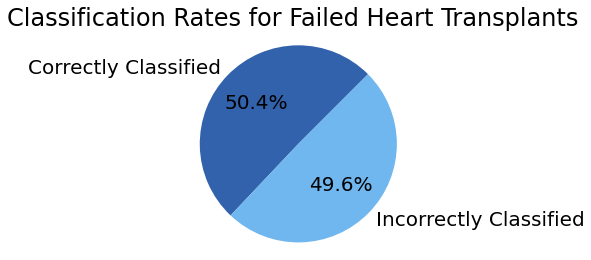

In [14]:
# Pie chart for classification of successful and failed transplants

transplants_pie_chart('success',9418,190)
transplants_pie_chart('failed',588,578)

/Users/trev/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/trev/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_utils.py:13: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/trev/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_utils.py:15: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



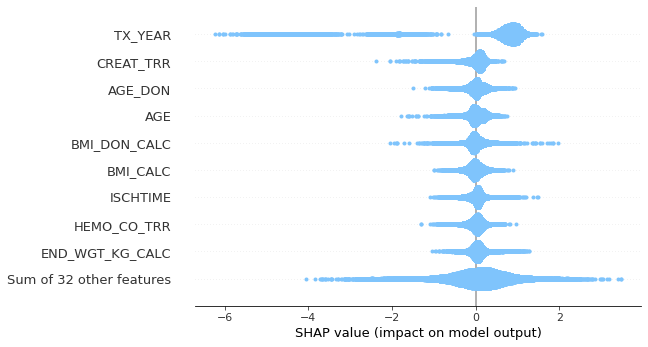

In [15]:
# Visualization to determine the most important features. Larger the area, more impact on classification

import shap
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values, color=np.array([127., 196, 252])/255)

Model 3: Random Forest algorithm on the physician-specified features

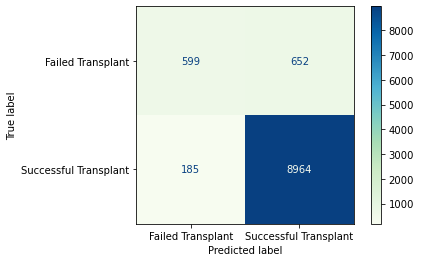

In [16]:
# Try a random forest algorithm

df_2 = df_1.dropna()

X = df_2.drop(['365DaySurvival'], axis = 1)
y = df_2['365DaySurvival']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Failed Transplant','Successful Transplant'], cmap = 'GnBu')
plt.show()

In [17]:
metrics(y_test, y_pred)

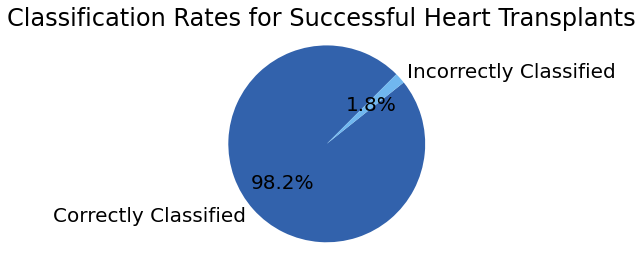

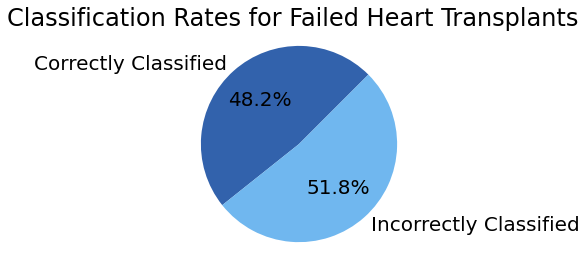

In [18]:
transplants_pie_chart('success',8986,163)
transplants_pie_chart('failed',603,648)

Use SMOTE to balance the dataset with oversampling of the minority class (failed transplants)

In [19]:
df_smote = df_1.dropna()

X = df_smote.drop(['365DaySurvival'], axis = 1)
y = df_smote['365DaySurvival']

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({True: 36849, False: 36849})


Model 4: XGBoost algorithm on physician-specified features after SMOTE oversampling has been applied

In [20]:
model = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

metrics(y_test, y_pred)

0.9433514246947082


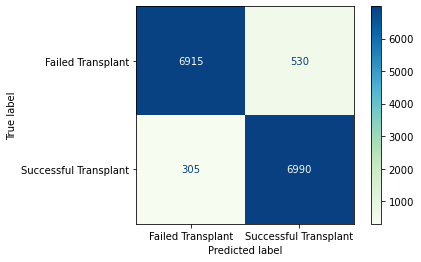

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Failed Transplant','Successful Transplant'], cmap = 'GnBu')
plt.show()

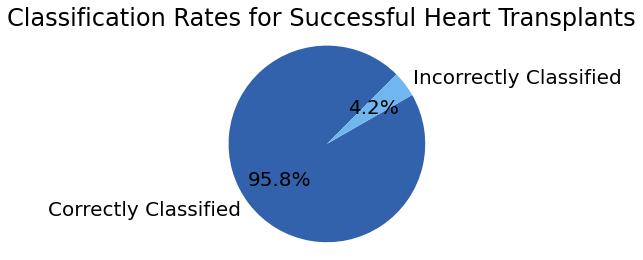

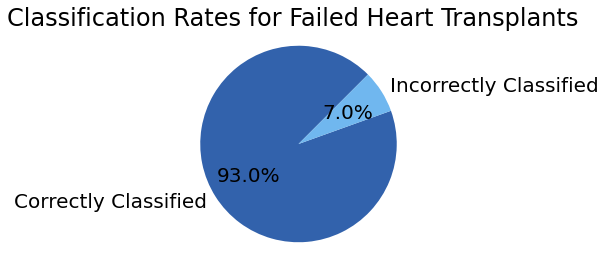

In [22]:
transplants_pie_chart('success',6988,307)
transplants_pie_chart('failed',6923,522)

Model 5: XGBoost classifier algorithm on pysician-specified features after SMOTE oversampling and Tomek undersampling techniques

In [23]:
X = df_smote.drop(['365DaySurvival'], axis = 1)
y = df_smote['365DaySurvival']

smt = SMOTETomek(random_state=42)
X, y = smt.fit_resample(X, y)

model = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

metrics(y_test, y_pred)

0.94597566843082


In [24]:
print(len(X))
print(len(y))

72744
72744


Model 6: XGBoost classifier algorithm on pysician-specified features after SMOTE oversampling and ENN undersampling techniques

In [25]:
X = df_smote.drop(['365DaySurvival'], axis = 1)
y = df_smote['365DaySurvival']

smt = SMOTEENN(random_state=42)
X, y = smt.fit_resample(X, y)

model = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

metrics(y_test, y_pred)

0.9618738245853992


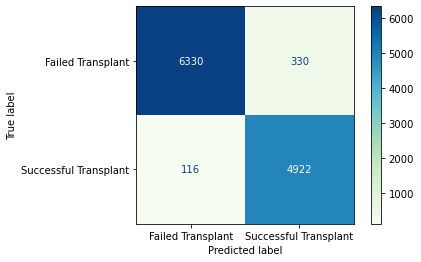

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Failed Transplant','Successful Transplant'], cmap = 'GnBu')
plt.show()

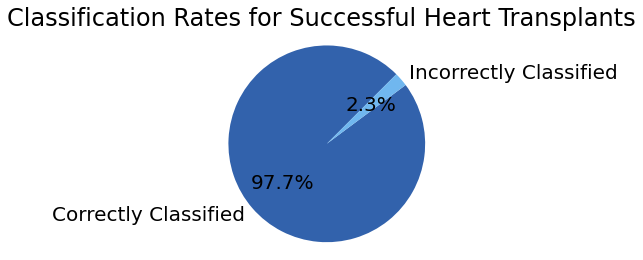

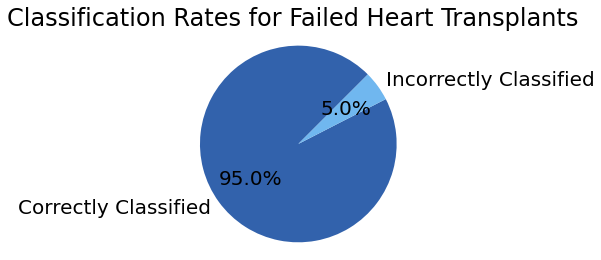

In [27]:
transplants_pie_chart('success',4922,116)
transplants_pie_chart('failed',6330,330)

Cross validation on Model 5

In [28]:
from sklearn.model_selection import cross_validate
scores = cross_validate(model, X, y, cv=10, scoring=['accuracy','precision','recall','f1','roc_auc'])

print(scores)

{'fit_time': array([2.79763508, 2.46020389, 2.56141901, 2.70170021, 2.33495092,
       2.38428307, 2.54456282, 2.43709612, 2.40738988, 2.35500884]), 'score_time': array([0.02605605, 0.02789998, 0.02671981, 0.02711487, 0.02898407,
       0.02593207, 0.02561593, 0.02844   , 0.02617216, 0.02752995]), 'test_accuracy': array([0.79381091, 0.92614122, 0.9871773 , 0.98803214, 0.96990939,
       0.98734826, 0.98341597, 0.98529663, 0.97948367, 0.98922893]), 'test_precision': array([0.676957  , 0.86987779, 0.99065421, 0.99307253, 0.98695835,
       0.98788857, 0.9921875 , 0.98546629, 0.98886598, 0.99349593]), 'test_recall': array([0.98634538, 0.97188755, 0.97911647, 0.97871486, 0.94179045,
       0.98233641, 0.96868727, 0.97992774, 0.9626656 , 0.98113208]), 'test_f1': array([0.80287676, 0.91805766, 0.98485155, 0.98584142, 0.96384552,
       0.98510467, 0.98029657, 0.98268921, 0.97558991, 0.9872753 ]), 'test_roc_auc': array([0.88433938, 0.96431741, 0.99746387, 0.9987562 , 0.99575004,
       0.9986

Model 6: SVM classifier algorithm on physician-specified features

In [29]:
from sklearn.svm import SVC

model_svm = SVC()
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
print(accuracy_score(y_test, y_pred))

metrics(y_test, y_pred)


0.6649854676012994


Model 7: XGBoost classifier algorithm on phyisican-specified features (except TX_YEAR) with SMOTE oversampling and ENN undersampling techniques

In [30]:
df_no_year = df_smote.drop('TX_YEAR', axis=1)

In [31]:
from imblearn.combine import SMOTEENN

X = df_no_year.drop(['365DaySurvival'], axis = 1)
y = df_no_year['365DaySurvival']

smt = SMOTEENN(random_state=42)
X, y = smt.fit_resample(X, y)

model = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

metrics(y_test, y_pred)

0.9103575952450551


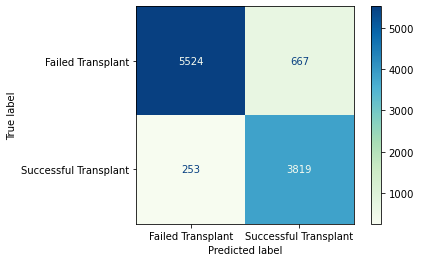

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Failed Transplant','Successful Transplant'], cmap = 'GnBu')
plt.show()

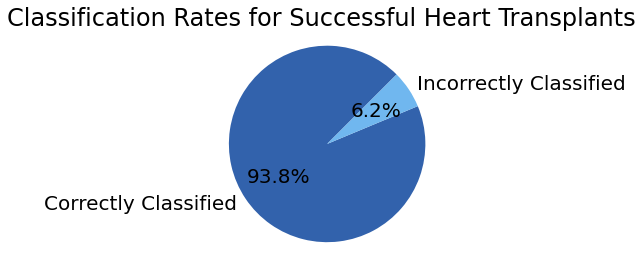

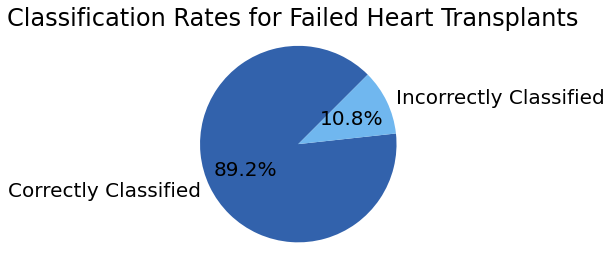

In [33]:
transplants_pie_chart('success',3819,253)
transplants_pie_chart('failed',5524,667)

Cross validation on Model 7

In [34]:
scores = cross_validate(model, X, y, cv=10, scoring=['accuracy','precision','recall','f1','roc_auc'])

print(scores)

{'fit_time': array([2.52530503, 2.35581684, 2.21000695, 2.24795699, 2.09336185,
       2.08898306, 2.10239482, 2.07333422, 2.20704889, 2.02893782]), 'score_time': array([0.02374005, 0.0252099 , 0.02463913, 0.02242208, 0.02253628,
       0.02514362, 0.02506804, 0.02316594, 0.02721   , 0.02316427]), 'test_accuracy': array([0.43978956, 0.82112237, 0.96998636, 0.9719353 , 0.95342039,
       0.9719353 , 0.96940168, 0.97096083, 0.9623855 , 0.97349445]), 'test_precision': array([0.40919445, 0.70164302, 0.98782425, 0.98840274, 0.98563536,
       0.9828125 , 0.98729487, 0.98837824, 0.98287854, 0.98948475]), 'test_recall': array([0.98898899, 0.94044044, 0.9344016 , 0.93890836, 0.89334001,
       0.94444444, 0.93343343, 0.93643644, 0.91941942, 0.94194194]), 'test_f1': array([0.57887798, 0.80367836, 0.96037056, 0.96302003, 0.93722091,
       0.96324655, 0.95960895, 0.9617065 , 0.95009051, 0.96512821]), 'test_roc_auc': array([0.69951381, 0.89606725, 0.99838782, 0.99758029, 0.99001997,
       0.9975

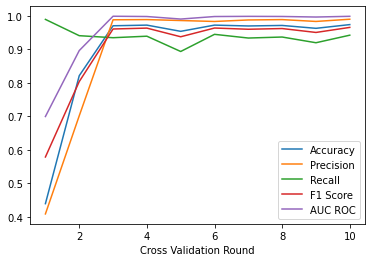

In [35]:
round = [1,2,3,4,5,6,7,8,9,10]
accuracies = scores['test_accuracy']
precisions = scores['test_precision']
recalls = scores['test_recall']
f1s = scores['test_f1']
roc_aucs = scores['test_roc_auc']

plt.plot(round, accuracies, label = 'Accuracy')
plt.plot(round, precisions, label = 'Precision')
plt.plot(round, recalls, label = 'Recall')
plt.plot(round, f1s, label = 'F1 Score')
plt.plot(round, roc_aucs, label = 'AUC ROC')
plt.legend()
plt.xlabel("Cross Validation Round")
plt.show()

/Users/trev/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/trev/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_utils.py:13: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/trev/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_utils.py:15: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



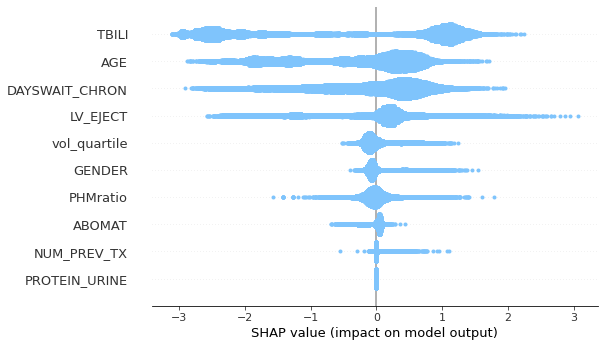

In [36]:
# Feature importance visualization for Model 7
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values, color=np.array([127., 196, 252])/255)

In [37]:
df_smote.corr()

,365DaySurvival,GENDER,LV_EJECT,NUM_PREV_TX,DAYSWAIT_CHRON,ABOMAT,TX_YEAR,PHMratio,vol_quartile,TBILI,PROTEIN_URINE,AGE
365DaySurvival,1.000000,-0.003000,0.003967,-0.002066,0.020762,0.009024,-0.281840,-0.009110,0.013481,-0.007084,NaN,-0.011812
GENDER,-0.003000,1.000000,0.021201,0.030783,-0.060643,-0.021271,0.030490,0.416468,-0.000692,-0.031153,NaN,-0.136588
LV_EJECT,0.003967,0.021201,1.000000,0.001348,0.005040,-0.006601,-0.001969,0.015193,-0.007434,-0.000264,NaN,-0.007531
NUM_PREV_TX,-0.002066,0.030783,0.001348,1.000000,-0.003511,-0.009206,-0.018888,0.006140,0.032520,0.002814,NaN,-0.106349
DAYSWAIT_CHRON,0.020762,-0.060643,0.005040,-0.003511,1.000000,0.109755,-0.008058,-0.064131,-0.039088,-0.031577,NaN,0.023836
ABOMAT,0.009024,-0.021271,-0.006601,-0.009206,0.109755,1.000000,-0.001983,-0.030473,0.003952,-0.026779,NaN,0.014240
TX_YEAR,-0.281840,0.030490,-0.001969,-0.018888,-0.008058,-0.001983,1.000000,0.005438,-0.028679,-0.064161,NaN,0.051840
PHMratio,-0.009110,0.416468,0.015193,0.006140,-0.064131,-0.030473,0.005438,1.000000,-0.014588,0.005936,NaN,-0.017305
vol_quartile,0.013481,-0.000692,-0.007434,0.032520,-0.039088,0.003952,-0.028679,-0.014588,1.000000,-0.001310,NaN,0.034046
TBILI,-0.007084,-0.031153,-0.000264,0.002814,-0.031577,-0.026779,-0.064161,0.005936,-0.001310,1.000000,NaN,-0.031167
